In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras import backend as K
import albumentations as A
from functools import partial
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
seed = 42
np.random.seed(seed)

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_img_folder_path = "/content/drive/MyDrive/archive (2)/ISIC2018_Task1-2_Training_Input"
train_label_folder_path = "/content/drive/MyDrive/archive (2)/ISIC2018_Task1_Training_GroundTruth"
val_folder_path = "/content/drive/MyDrive/archive (2)/ISIC2018_Task1-2_Validation_Input"
test_folder_path = "/content/drive/MyDrive/archive (2)/ISIC2018_Task1-2_Test_Input"


In [6]:
# This array contains paths for the images. Folder contains a text file, we only want images I used endswith function to get jpg files
train_images_path = np.sort([os.path.join(train_img_folder_path, i) for i in os.listdir(train_img_folder_path) if i.endswith(('.jpg','.png'))])
train_labels_path = np.sort([os.path.join(train_label_folder_path, i) for i in os.listdir(train_label_folder_path) if i.endswith(('.jpg','.png'))])
test_images_path = np.sort([os.path.join(test_folder_path, i) for i in os.listdir(test_folder_path) if i.endswith(('.jpg','.png'))])

In [7]:
train_split = 0.8
val_images_path = train_images_path[int(train_split*len(train_images_path)):]
val_labels_path = train_labels_path[int(train_split*len(train_labels_path)):]
train_images_path = train_images_path[:int(train_split*len(train_images_path))]
train_labels_path = train_labels_path[:int(train_split*len(train_labels_path))]

In [8]:
len(train_labels_path)

2075

In [9]:



len(val_labels_path)


519

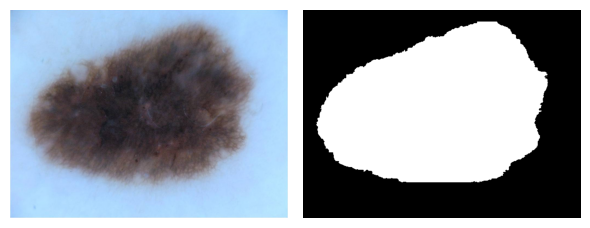

In [10]:




img1 = Image.open(train_images_path[0])
img1_label = Image.open(train_labels_path[0])

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img1_label, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show();

In [11]:
IMG_SIZE = 256
IMG_CHANNELS = 3
batch_size = 8
buffer_size = 1000
steps_per_epoch = len(train_images_path) // batch_size
AUTOTUNE = tf.data.AUTOTUNE

In [12]:
x_train_ds = tf.data.Dataset.list_files(train_images_path, seed=seed)
y_train_ds = tf.data.Dataset.list_files(train_labels_path, seed=seed)
x_val_ds = tf.data.Dataset.list_files(val_images_path, seed=seed)
y_val_ds = tf.data.Dataset.list_files(val_labels_path, seed=seed)

In [13]:
def parse_image(img_path, size=(256,256)):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size)
    return image

def parse_gt(gt_path, size=(256,256)):
    gt = tf.io.read_file(gt_path)
    gt = tf.image.decode_png(gt, channels=1)
    gt = tf.image.resize(gt, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    gt = tf.where(gt == 0, 0, 1)
    gt = tf.image.convert_image_dtype(gt, tf.int32)
    return gt

In [14]:
x_train_ds = x_train_ds.map(parse_image)
y_train_ds = y_train_ds.map(parse_gt)
x_val_ds = x_val_ds.map(parse_image)
y_val_ds = y_val_ds.map(parse_gt)

In [15]:
train_ds = tf.data.Dataset.zip((x_train_ds, y_train_ds))
val_ds = tf.data.Dataset.zip((x_val_ds, y_val_ds))

In [16]:
def augment(image, mask, size=(256, 256)):
  transforms = A.Compose([
      A.OneOf([
          A.Transpose(),
          A.VerticalFlip(),
          A.HorizontalFlip(),
          A.RandomRotate90(),
          A.NoOp()], p=0.75),

      A.ShiftScaleRotate(p=0.1),
      A.GridDistortion(p=0.1),
      A.ElasticTransform(p=0.1),

      A.OneOf([
          A.RandomBrightnessContrast(),
          A.RandomGamma()], p=0.2)

    ], additional_targets={'mask': 'mask'})

  data = {"image":image, "mask":mask}
  aug_data = transforms(**data)

  aug_img = aug_data["image"]
  aug_img = tf.cast(aug_img, tf.float32)

  aug_mask = aug_data["mask"]
  # Making sure labels are binary (background or label)
  aug_mask = np.where(aug_mask == 0, 0, 1)
  aug_mask = tf.cast(aug_mask, tf.int32)
  return aug_img, aug_mask

In [17]:
# I used tf.numpy_function()
def process_data(image, mask, h=256, w=256):
  image, mask = tf.numpy_function(func=augment, inp=[image, mask], Tout=(tf.float32, tf.int32))
  # The datasets loses its shape after applying a tf.numpy_function, so this is
  # necessary for the sequential model and when inheriting from the model class.
  image.set_shape((h, w, 3))
  mask.set_shape((h, w, 1))
  return image, mask

In [18]:
train_ds = (
    train_ds
    .cache()
    .map(partial(process_data))
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=AUTOTUNE)
)

# validation data isn't augmented since model needs to be validated on real world data
val_ds = (
    val_ds
    .cache()
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=AUTOTUNE)
)

In [19]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int32, name=None))

(8, 256, 256, 3)
(8, 256, 256, 1)


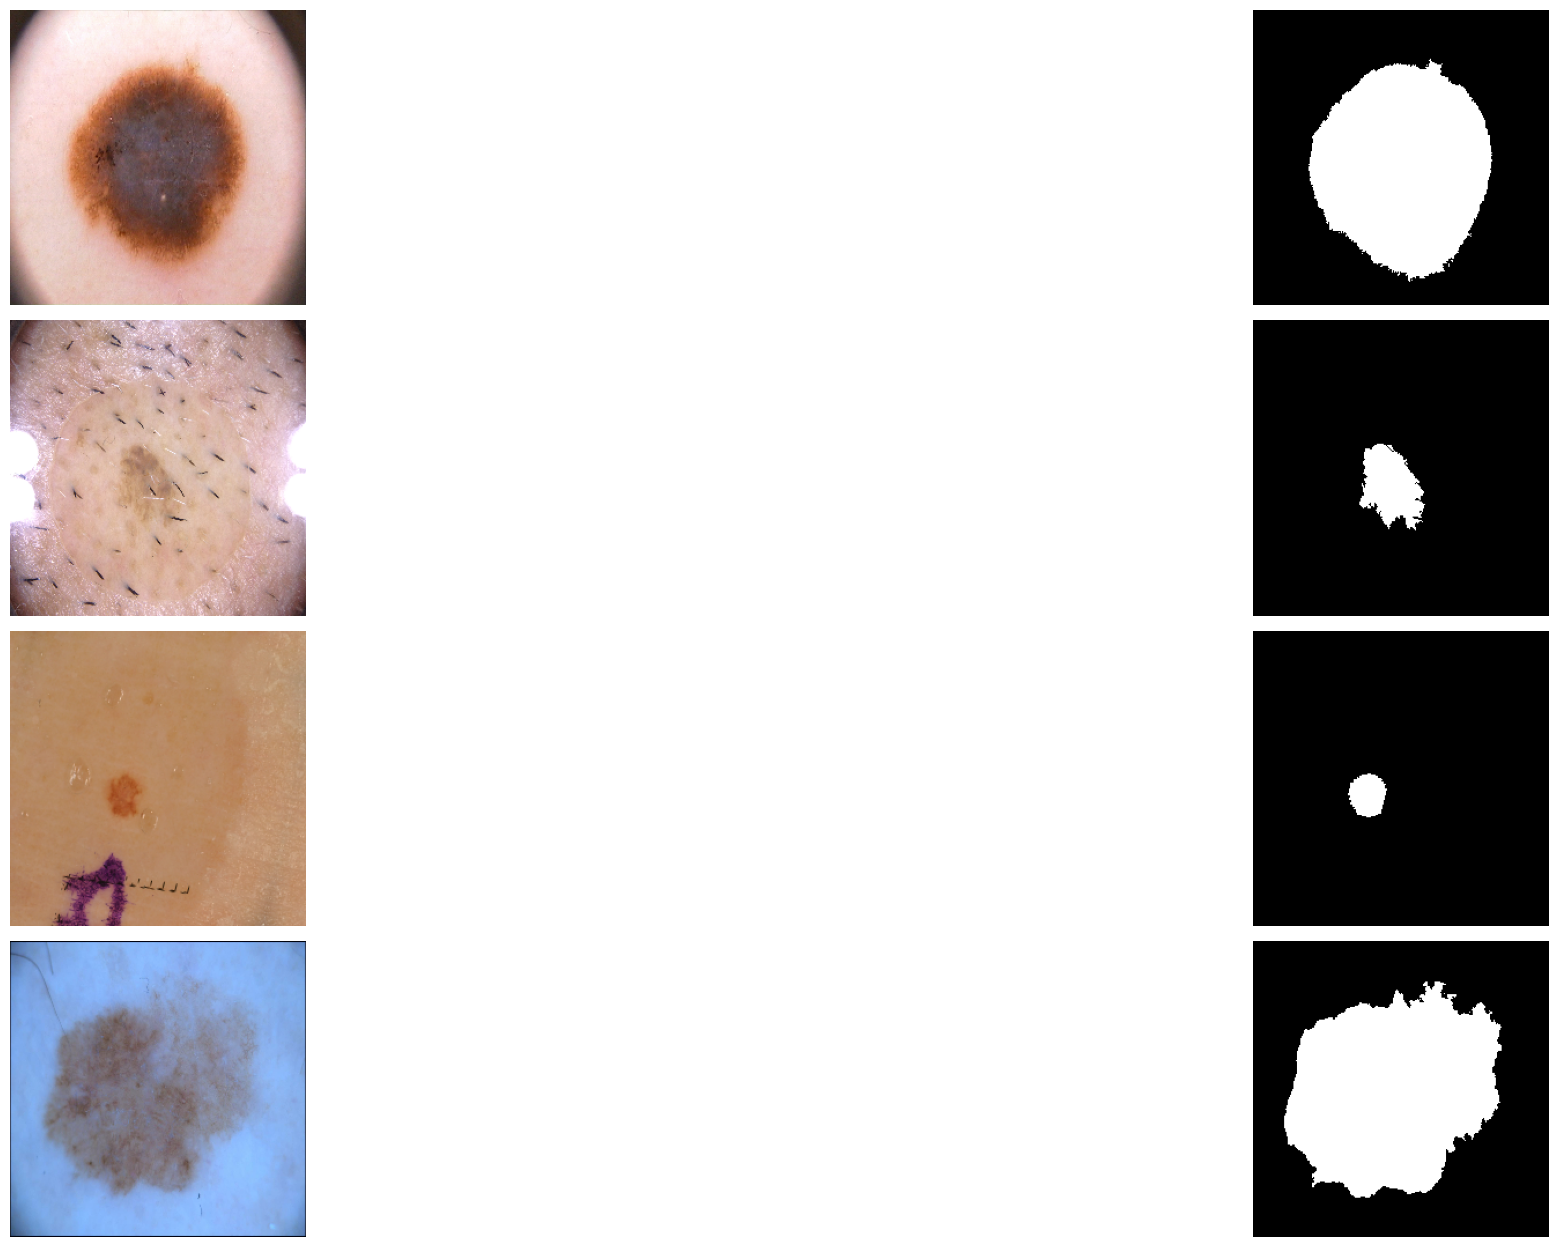

In [20]:
for image, label in train_ds.take(1):
    print(image.shape)
    print(label.shape)
    plt.figure(figsize=(25, 25))
    for i in range(0, batch_size, 2):
        plt.subplot(batch_size, 2, i+1)
        plt.imshow(image[i])
        plt.axis('off')
        plt.subplot(batch_size, 2, i+2)
        plt.imshow(label[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

In [21]:
test_ds = (
    tf.data.Dataset.list_files(test_images_path)
    .map(parse_image)
    .batch(1))

In [22]:
test_ds.element_spec


TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)

MODEL ARCHITECTURE CODE

In [23]:
# Functions to build the encoder path
def conv_block(inp, filters, padding='same', activation='relu'):
    x = Conv2D(filters, (3, 3), padding=padding, activation=activation)(inp)
    x = Conv2D(filters, (3, 3), padding=padding)(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation)(x)
    return x

def encoder_block(inp, filters, padding='same', pool_stride=2, activation='relu'):
    # Encoder block of a UNet passes the result from the convolution block
    # above to a max pooling layer
    x = conv_block(inp, filters, padding, activation)
    p = MaxPooling2D(pool_size=(2, 2), strides=pool_stride)(x)
    return x, p

def attention_gate(skip_connection, gating_signal, filters, padding='same'):
    """
    Compute attention weights for a skip connection in the U-Net.
    """
    # Downsample skip connection to match gating signal dimensions
    theta_x = Conv2D(filters, (1, 1), strides=(1, 1), padding=padding)(skip_connection)
    # Downsample gating signal
    phi_g = Conv2D(filters, (1, 1), strides=(1, 1), padding=padding)(gating_signal)

    # Upsample gating signal to match skip connection dimensions
    phi_g = tf.keras.layers.UpSampling2D(size=(theta_x.shape[1] // phi_g.shape[1],
                                               theta_x.shape[2] // phi_g.shape[2]))(phi_g)

    # Combine the skip connection and gating signal
    add = tf.keras.layers.Add()([theta_x, phi_g])
    # Apply activation
    act = Activation('relu')(add)
    # Compute attention weights
    psi = Conv2D(1, (1, 1), strides=(1, 1), padding=padding)(act)
    psi = Activation('sigmoid')(psi)
    # Upsample the attention weights to match skip connection dimensions
    psi = tf.keras.layers.UpSampling2D(size=(skip_connection.shape[1] // psi.shape[1],
                                             skip_connection.shape[2] // psi.shape[2]))(psi)
    # Apply attention weights
    out = Multiply()([skip_connection, psi])
    return out



def decoder_block_with_attention(inp, filters, concat_layer, gating_signal, padding='same'):
    # Apply the attention gate to the encoder features
    attention_output = attention_gate(concat_layer, gating_signal, filters, padding)
    # Upsample the feature maps
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding=padding)(inp)
    # Concatenate the attention-modulated encoder features
    x = concatenate([x, attention_output])
    # Pass through the convolution block
    x = conv_block(x, filters)
    return x

def build_model_with_attention(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # Encoder path
    d1, p1 = encoder_block(inputs, 64)
    d2, p2 = encoder_block(p1, 128)
    d3, p3 = encoder_block(p2, 256)
    d4, p4 = encoder_block(p3, 512)
    # Bottleneck
    mid = conv_block(p4, 1024)
    # Decoder path with attention gates
    e2 = decoder_block_with_attention(mid, 512, d4, mid)
    e3 = decoder_block_with_attention(e2, 256, d3, e2)
    e4 = decoder_block_with_attention(e3, 128, d2, e3)
    e5 = decoder_block_with_attention(e4, 64, d1, e4)
    # Final output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(e5)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name='Attention_Unet')
    return model

In [24]:
# Metrics
def dice_coef(y_true, y_pred):
    smooth = 1e-7
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

# Specificity Metric
def specificity(y_true, y_pred):
    """
    Specificity: True Negatives / (True Negatives + False Positives)
    """
    smooth = 1e-7  # To avoid division by zero

    # Flatten and cast tensors to float32
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')

    # Compute True Negatives and False Positives
    true_negatives = K.sum((1 - y_true_f) * (1 - y_pred_f))
    false_positives = K.sum((1 - y_true_f) * y_pred_f)

    # Specificity calculation
    specificity_score = (true_negatives + smooth) / (true_negatives + false_positives + smooth)
    return specificity_score

# Sensitivity Metric
def sensitivity(y_true, y_pred):
    """
    Sensitivity (Recall): True Positives / (True Positives + False Negatives)
    """
    smooth = 1e-7  # To avoid division by zero

    # Flatten and cast tensors to float32
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')

    # Compute True Positives and False Negatives
    true_positives = K.sum(y_true_f * y_pred_f)
    false_negatives = K.sum(y_true_f * (1 - y_pred_f))

    # Sensitivity calculation
    sensitivity_score = (true_positives + smooth) / (true_positives + false_negatives + smooth)
    return sensitivity_score


In [25]:
# Loss

def bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, dtype=y_pred.dtype)
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    dice = dice_coef(y_true, y_pred)
    return bce - K.log(dice)

def bce_dice_loss_log(y_true, y_pred):
    y_true = K.cast(y_true, dtype=y_pred.dtype)
    bce = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    dice = dice_coef(y_true, y_pred)
    return bce + 1 - dice

In [26]:
IMG_SIZE = 256 #Assuming you want the height and width to be the same as IMG_SIZE defined earlier.
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
IMG_CHANNELS = 3
model = build_model_with_attention(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=bce_dice_loss_log,
              metrics=[dice_coef, iou,'accuracy',specificity,sensitivity])
model.summary()


Model: "Attention_Unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 32,090,885 (122.42 MB)

 Trainable params: 32,084,997 (122.39 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [27]:
steps_per_epoch = int(len(train_images_path)*0.8 // batch_size)
val_steps = int(len(train_images_path)*0.2 // batch_size)

print(f"Batch Size: {batch_size}\nSteps_per_epoch: {steps_per_epoch}\nValidation_steps: {val_steps}")

Batch Size: 8
Steps_per_epoch: 207
Validation_steps: 51


In [28]:
callbacks = [
    EarlyStopping(monitor='val_dice_coef', patience=10, mode='max'),
    ModelCheckpoint(filepath='saved_model.keras', monitor='val_dice_coef', save_best_only=True),
    ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, patience=5, verbose=1, min_lr=5e-7)
]

In [29]:
history = model.fit(train_ds, epochs=35, verbose=2,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=val_steps,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/35
207/207 - 95s - 457ms/step - accuracy: 0.8651 - dice_coef: 0.5742 - iou: 0.4119 - loss: 0.7848 - sensitivity: 0.6475 - specificity: 0.8689 - val_accuracy: 0.8154 - val_dice_coef: 0.5466 - val_iou: 0.3889 - val_loss: 1.2363 - val_sensitivity: 0.4612 - val_specificity: 0.9457 - learning_rate: 0.0010
Epoch 2/35
207/207 - 53s - 255ms/step - accuracy: 0.9050 - dice_coef: 0.6880 - iou: 0.5307 - loss: 0.5781 - sensitivity: 0.7148 - specificity: 0.9313 - val_accuracy: 0.7676 - val_dice_coef: 0.6555 - val_iou: 0.4934 - val_loss: 1.4479 - val_sensitivity: 0.9481 - val_specificity: 0.6746 - learning_rate: 0.0010
Epoch 3/35
207/207 - 19s - 93ms/step - accuracy: 0.9170 - dice_coef: 0.7271 - iou: 0.5773 - loss: 0.5071 - sensitivity: 0.7491 - specificity: 0.9404 - val_accuracy: 0.8494 - val_dice_coef: 0.7419 - val_iou: 0.5965 - val_loss: 0.6728 - val_sensitivity: 0.9128 - val_specificity: 0.8065 - learning_rate: 0.0010
Epoch 4/35
207/207 - 19s - 93ms/step - accuracy: 0.9193 - dice_coef: 0.

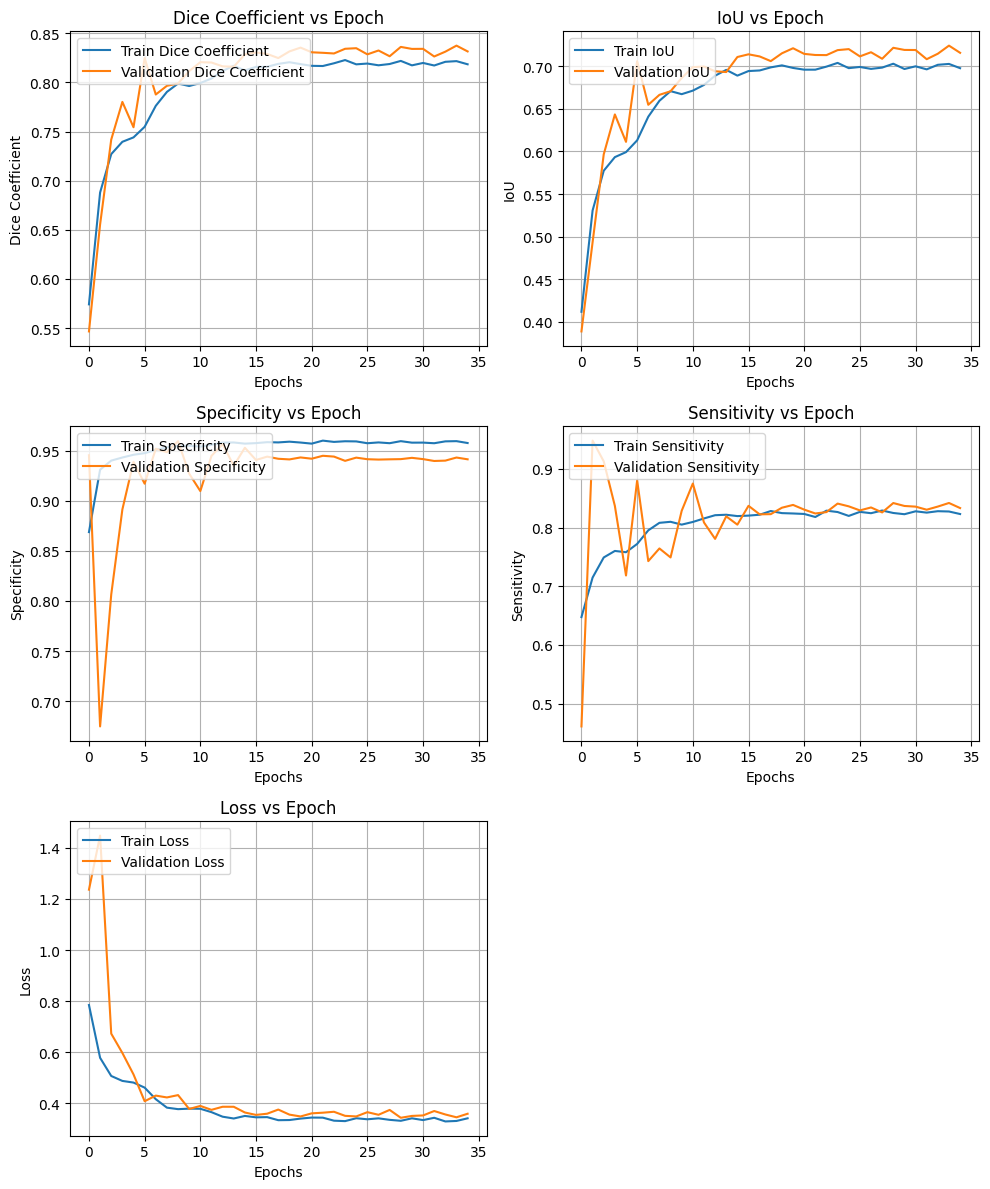

In [30]:
plt.figure(figsize=(10, 12))

# Dice Coefficient Plot
plt.subplot(3, 2, 1)
plt.plot(history.history['dice_coef'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# IoU Plot
plt.subplot(3, 2, 2)
plt.plot(history.history['iou'], label='Train IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.title('IoU vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Specificity Plot
plt.subplot(3, 2, 3)
plt.plot(history.history['specificity'], label='Train Specificity')
plt.plot(history.history['val_specificity'], label='Validation Specificity')
plt.title('Specificity vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Sensitivity Plot
plt.subplot(3, 2, 4)
plt.plot(history.history['sensitivity'], label='Train Sensitivity')
plt.plot(history.history['val_sensitivity'], label='Validation Sensitivity')
plt.title('Sensitivity vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Loss Plot
plt.subplot(3, 2, 5)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()

# Display all plots
plt.show()


In [31]:
# This function plots 25 random images with segmantation mask.
def plot_segmentation_images(image_path, image_label_path, size=512, Random=True):
    figure = plt.subplots(figsize=(25, 25))

    # plotting rows iterating through
    for i in range(25):
        random_number = np.random.randint(len(image_path)) if Random else i
        img = Image.open(image_path[random_number])
        img_label = Image.open(image_label_path[random_number])
        img = img.resize((size, size))
        img_label = img_label.resize((size, size))
        img = np.array(img)
        img_label = np.array(img_label)
        mask = np.ma.masked_where(img_label>0, img_label)
        img_label_mask = np.ma.masked_array(img_label, mask)
        img_name = image_label_path[random_number].split('/')[-1]

        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap='gray')
        plt.imshow(img_label_mask, cmap='jet', alpha=0.4)

    plt.show()

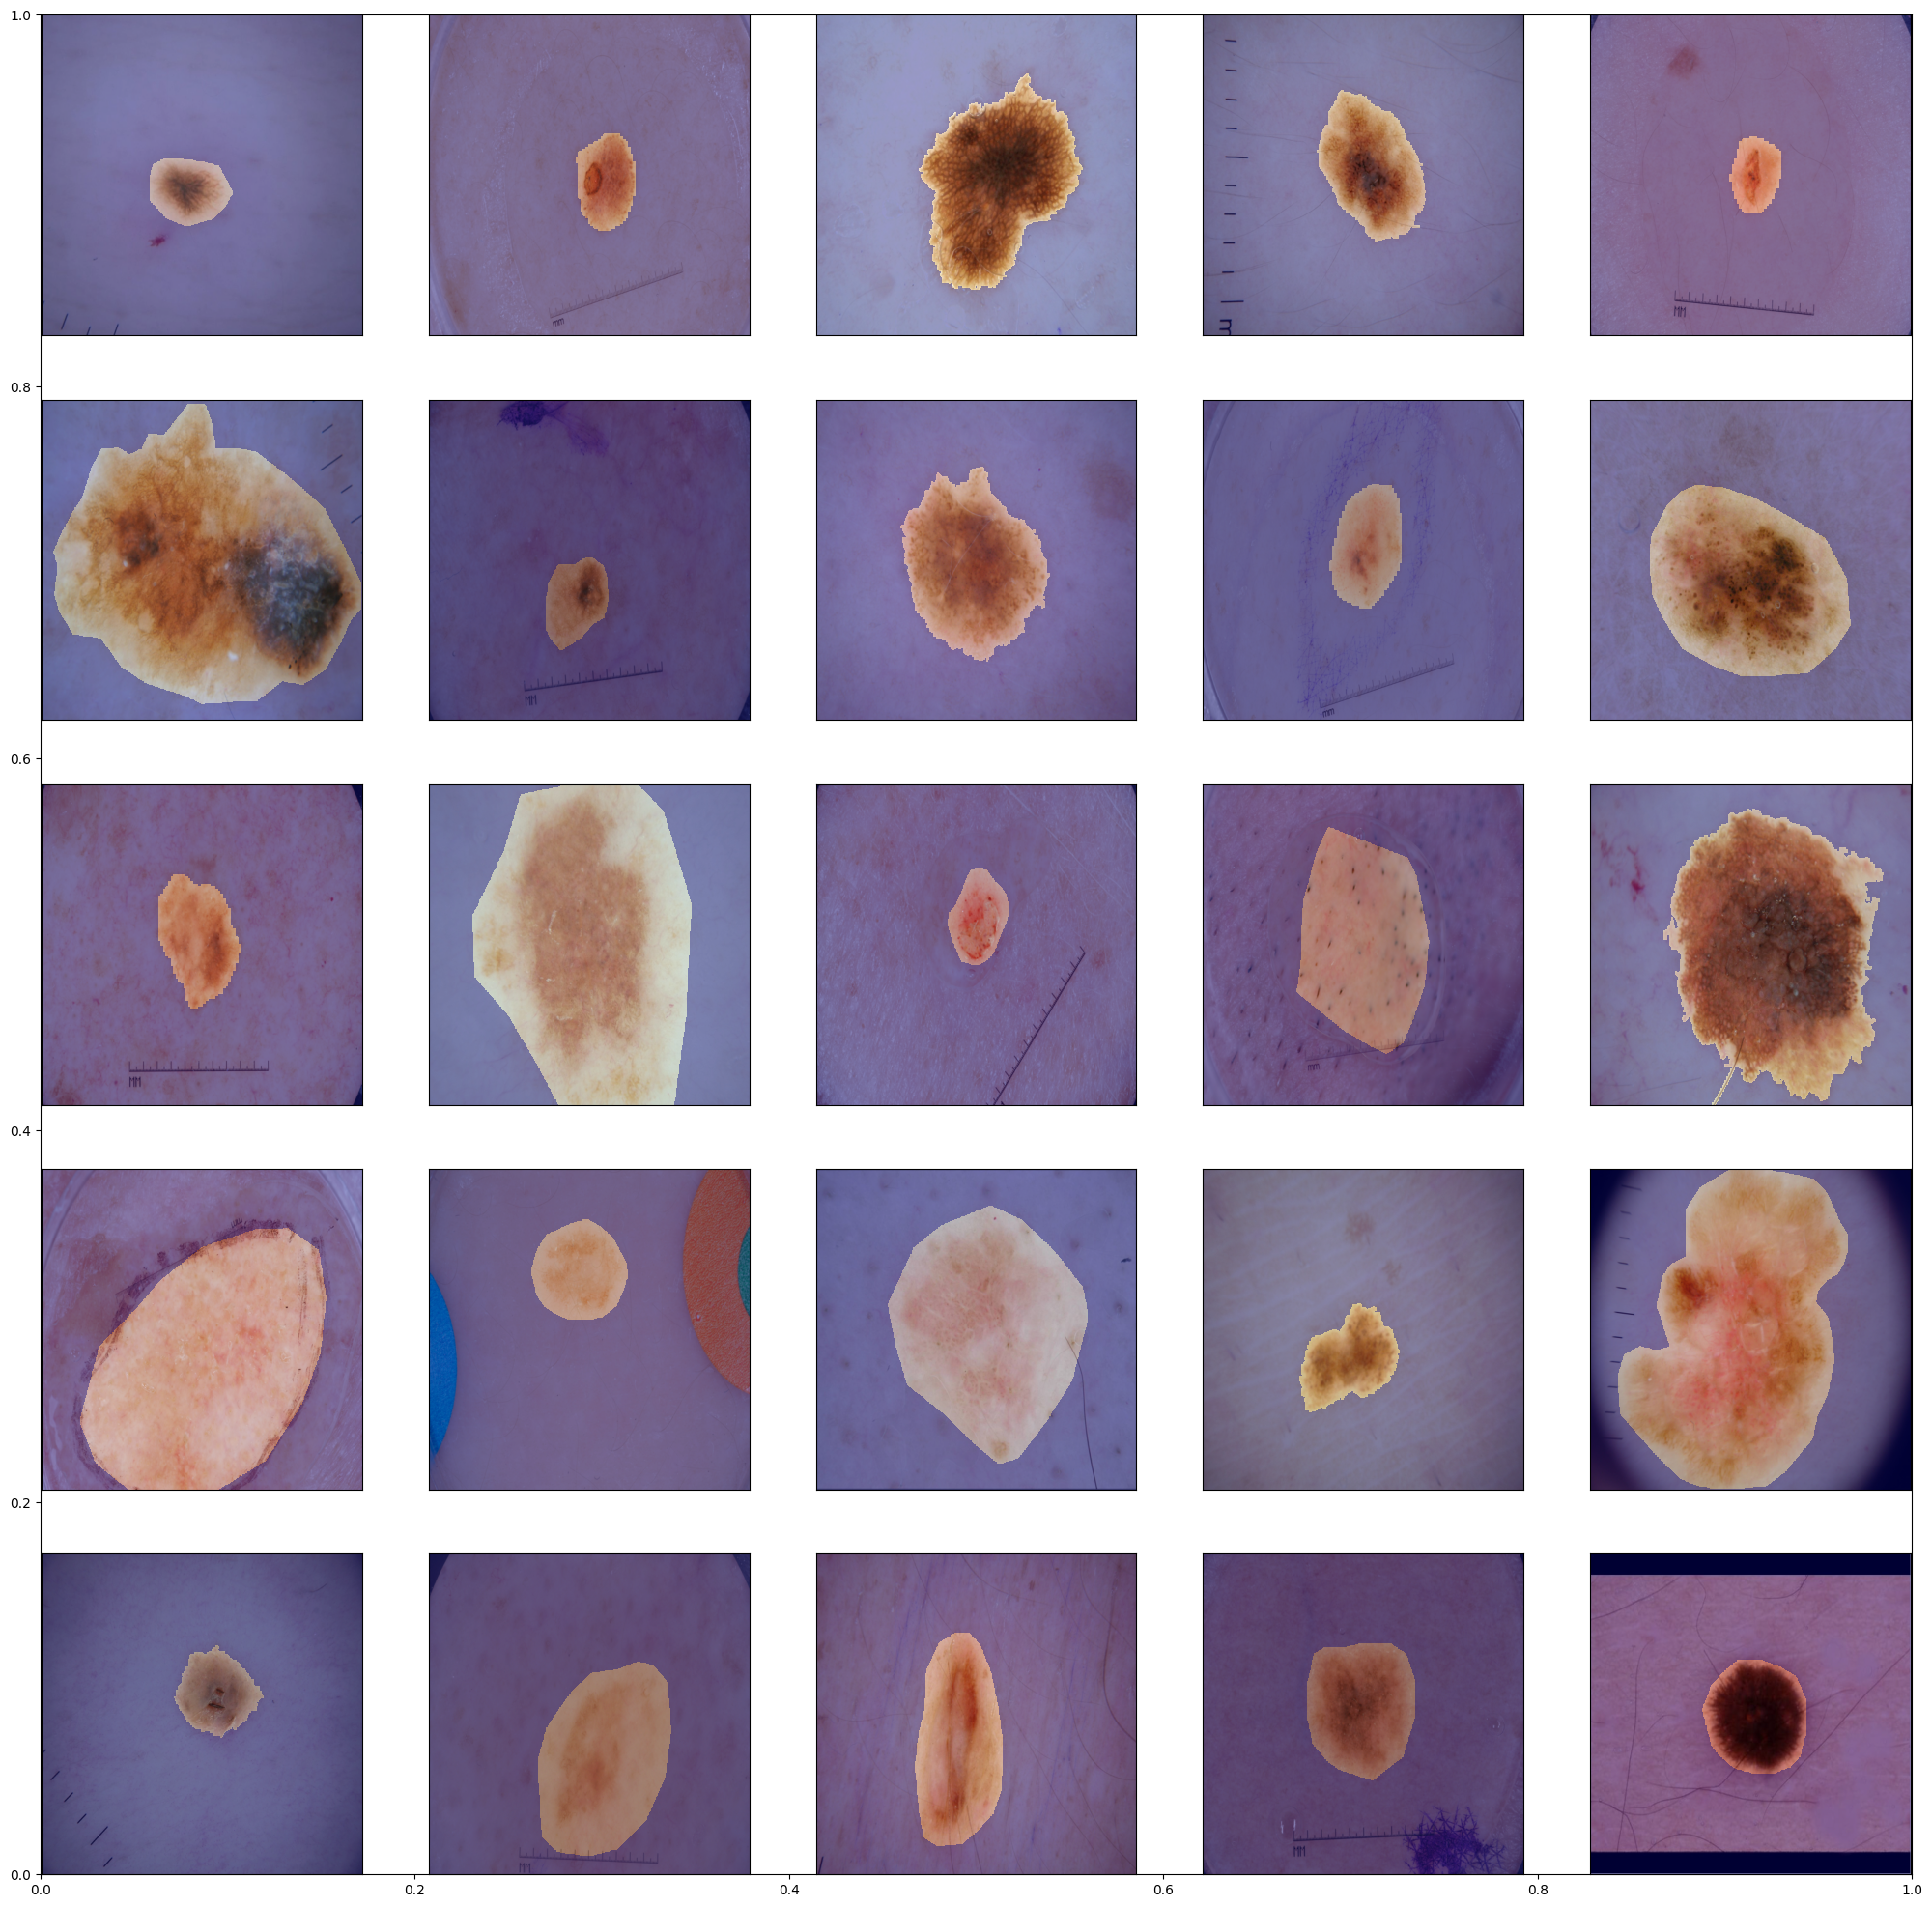

In [32]:
# Plots 25 random train images.
plot_segmentation_images(train_images_path, train_labels_path)

In [37]:
raw_predictions = model.predict(test_ds)

999/999 ━━━━━━━━━━━━━━━━━━━━ 91s 87ms/step


In [38]:
predictions = np.where(raw_predictions < 0.5, 0, 1)

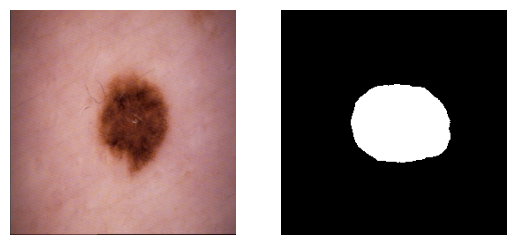

In [39]:
image = [images[0].numpy() for images in test_ds.take(1)]
# Looking at an example before creating saving outputs as image.
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(image[0]) # Using index 0 because it is in shape of (1, 256, 256, 1)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(predictions[0], cmap='gray')
plt.show()


In [40]:
if not os.path.exists('predictions'):
    os.makedirs('predictions')

# loop through the predictions and save each one as an image
for i, pred in tqdm(enumerate(predictions)):
    pred = (pred * 255).astype(np.uint8)
    image = Image.fromarray(pred.squeeze())
    filename = f"prediction_{i}.png"
    image.save(os.path.join('predictions', filename))

999it [00:01, 797.04it/s]


NOTE: Since we are dealing with a Kaggle Competition Dataset, we are not provided with the test ground truth. Thus, we cannot compute the test accuracy.
Instead, the predicted masks are visualized and inspected accordingly.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


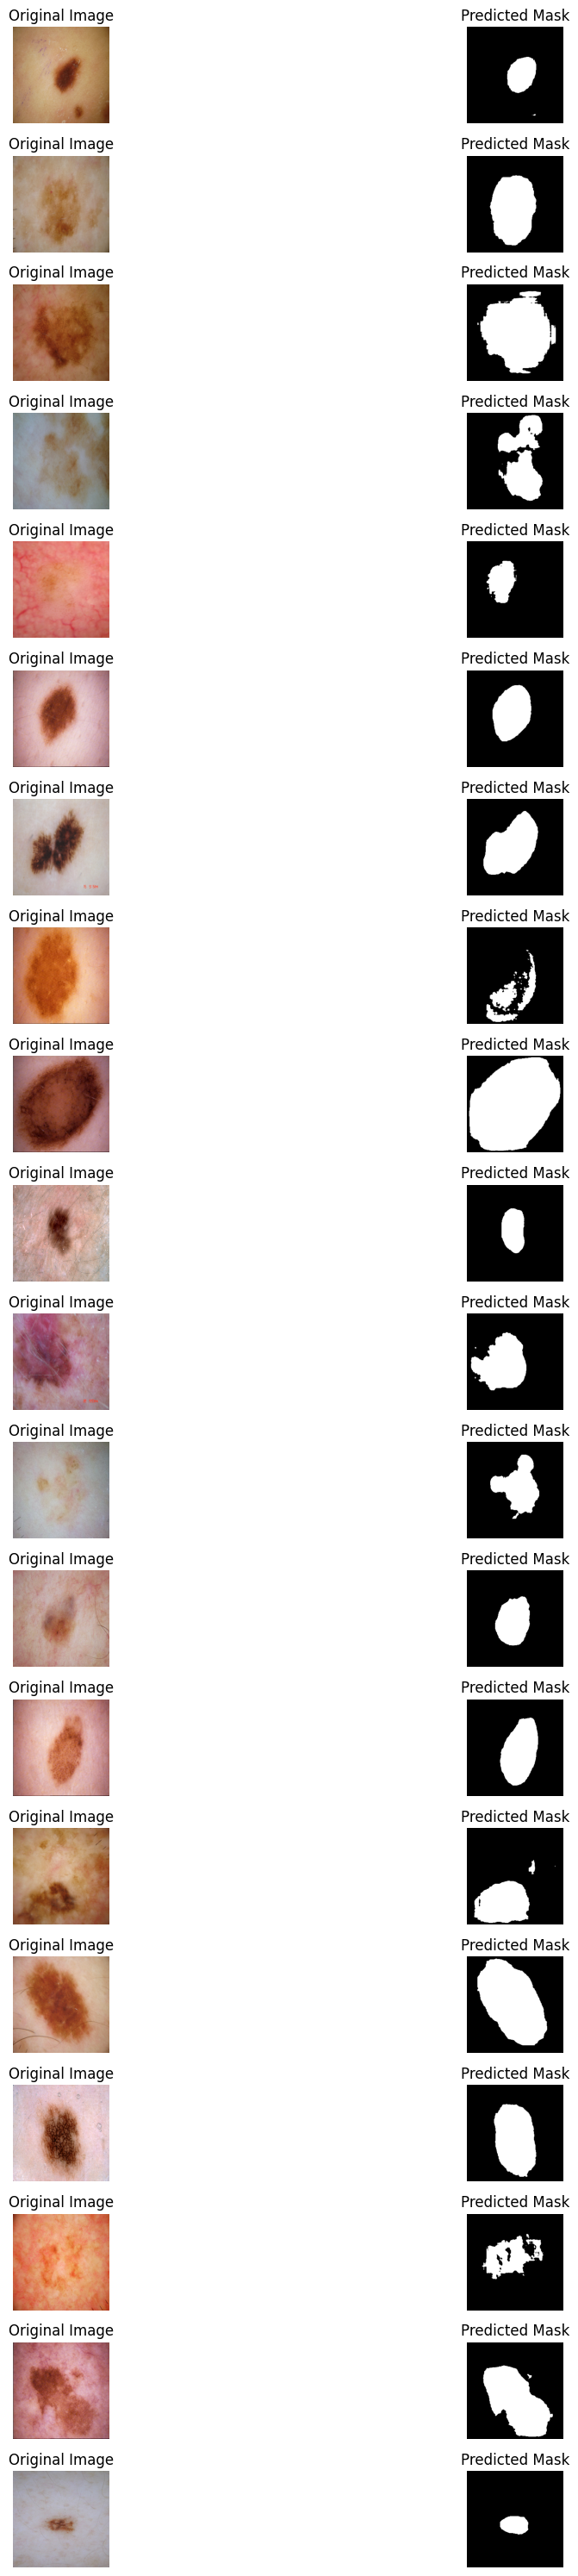

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize test images and predicted masks
def visualize_predictions(model, dataset, num_samples=20):
    # Convert dataset to a list of images for random sampling
    test_images = list(dataset.take(num_samples).as_numpy_iterator())

    # Plot settings
    plt.figure(figsize=(15, num_samples // 2 * 3))
    for i in range(num_samples):
        # Get the test image
        img = test_images[i][0]

        # Add batch dimension and predict mask
        prediction = model.predict(np.expand_dims(img, axis=0))[0]

        # Threshold the prediction for binary masks
        predicted_mask = (prediction > 0.5).astype(np.uint8)

        # Display original image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original Image")

        # Display predicted mask
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(predicted_mask, cmap="gray")
        plt.axis('off')
        plt.title("Predicted Mask")

    plt.tight_layout()
    plt.show()

# Visualize 20 samples and their predicted masks
visualize_predictions(model, test_ds, num_samples=20)
